# Set connection with GitHub

In [1]:
# ! cd /kaggle/working && rm -rf RECsys_Challenge2024

In [2]:
from kaggle_secrets import UserSecretsClient

token = UserSecretsClient().get_secret("Token")

! git clone https://{token}@github.com/madratak/RECsys_Challenge2024.git

Cloning into 'RECsys_Challenge2024'...
remote: Enumerating objects: 7608, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 7608 (delta 37), reused 2 (delta 1), pack-reused 7505 (from 3)
Receiving objects: 100% (7608/7608), 426.89 MiB | 22.41 MiB/s, done.
Resolving deltas: 100% (4141/4141), done.
Updating files: 100% (506/506), done.


In [3]:
! pip install PyGithub requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.9/375.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 26.1 MB/s eta 0:00:00


In [4]:
! pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.1 MB/s eta 0:00:00


In [5]:
!pip install timeout-decorator

  Preparing metadata (setup.py) ... done
  Created wheel for timeout-decorator: filename=timeout_decorator-0.5.0-py3-none-any.whl size=5005 sha256=b6ec6cb802b0d1c43c5b0b48cb7c716123561884c41cb4e8036a6f956092ebbd
  Stored in directory: /root/.cache/pip/wheels/68/2f/bc/76f1192d474666d41ae6f09813fccbd00fe3f07e8261c4cff5
Successfully built timeout-decorator


In [6]:
%cd /kaggle/working/RECsys_Challenge2024
! python run_compile_all_cython.py

/kaggle/working/RECsys_Challenge2024
run_compile_all_cython: Found 11 Cython files in 5 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/usr/bin/python3'
Compiling [1/11]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1252:
/usr/local/lib/python3.10/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wcpp-Wcpp]8;;]
   17 | #warning "Using deprecated NumPy API, disabl

In [7]:
from Utils.notebookFunctions import *
from Utils.xgboost_functions import *
import numpy as np
import pandas as pd
import scipy.sparse as sps
import time
import shutil
import optuna
import json
import os
import gc
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
from tqdm import tqdm
from xgboost import XGBRanker

import warnings
import string
from scipy.stats import skew, kurtosis
from numpy import linalg as LA

import timeout_decorator

%matplotlib inline
from xgboost import plot_importance

K_PATH = '/kaggle/working/RECsys_Challenge2024'
GH_PATH = 'TrainedModels/WithKFCV'
GH_PATH_1 = 'TrainedModels/WithoutKFCV'
D_PATH = 'XGBoost'

np.random.seed(42)

In [8]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.MatrixFactorization.FasterIALSRecommender import FasterIALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import ScaledPureSVDRecommender
from Recommenders.Neural.MultVAE_PyTorch_Recommender import MultVAERecommender_PyTorch_OptimizerMask 
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python

## Import the repository

In [9]:
repo = get_repo_from_github(token)

Repository 'RECsys_Challenge2024' found.


In [10]:
config = {
    'model': 'XGBoostNoCont',
    'metric': 'MAP',
    'categorical': True,
    'contents': False,
    'tune_parameters': True,
    'database_path': '/kaggle/working/history_XGBoostNoCont_MAP.db',
    'copy_prev_best_params': False,
    'tune_best_params': True,
    'save_github': True
}

Import the database where previous tuning trials have been saved.

In [11]:
try:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

Save the best trial value saved in the imported db from optuna.

In [12]:
try:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}')

    # Access the best trial
    best_saved_value = study.best_trial.value
except:
    best_saved_value = 0

print("Best value:", best_saved_value)

Best value: 0


# Construction of URM and ICM matrices

In [13]:
URM_all_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_train.csv")

n_users = len(URM_all_dataframe["user_id"].unique())
n_items = len(URM_all_dataframe["item_id"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["data"].values, 
                          (URM_all_dataframe["user_id"].values, URM_all_dataframe["item_id"].values)),
                        shape = (n_users, n_items))

URM_all

<35736x38121 sparse matrix of type '<class 'numpy.float64'>'
	with 1764607 stored elements in Compressed Sparse Row format>

In [14]:
ICM_dataframe = pd.read_csv("/kaggle/input/recommender-system-2024-challenge-polimi/data_ICM_metadata.csv")

n_items = len(ICM_dataframe["item_id"].unique())
n_features = len(ICM_dataframe["feature_id"].unique())

ICM_all = sps.csr_matrix((ICM_dataframe["data"].values, 
                          (ICM_dataframe["item_id"].values, ICM_dataframe["feature_id"].values)),
                        shape = (n_items, n_features))

ICM_all

<38121x94331 sparse matrix of type '<class 'numpy.float64'>'
	with 2940040 stored elements in Compressed Sparse Row format>

## Import dataframes

In [15]:
dataframes_path = f'/kaggle/input/dataframes-{config["model"].lower()}-kfcv'

if os.path.exists(dataframes_path):
    print("Dataframe directory is ready to be used.")
else:
    print("No dataframes directory is present.")

Dataframe directory is ready to be used.


# Training
Split the dataset in train, validation and test set.

In [16]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 141 ( 0.4%) Users that have less than 1 test interactions


Function to fit the hybrid recommender that is going to be used as candidate generator.

## Candidate Generators

Select the best previously trained recommenders to use inside the hybrid recommender (candidate generator).

In [17]:
cg_recommenders = {
    "ItemKNNCF": ItemKNNCFRecommender,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "RP3beta": RP3betaRecommender,
}

## Features
Select the other previously trained recommenders to use them as features.

In [18]:
f_recommenders = {
    "RP3beta": RP3betaRecommender,
    "P3alpha": P3alphaRecommender,
    "ItemKNNCF": ItemKNNCFRecommender,
    "ItemKNNCBF": ItemKNNCBFRecommender,
    "UserKNNCF": UserKNNCFRecommender,
    "FasterIALS": FasterIALSRecommender,
    "NMF": NMFRecommender,
    "PureSVDItem": PureSVDItemRecommender,
    "ScaledPureSVD": ScaledPureSVDRecommender,
    "MultVAE": MultVAERecommender_PyTorch_OptimizerMask,
    "SLIMElasticNet": SLIMElasticNetRecommender,
    "SLIM_BPR": SLIM_BPR_Python,
}

## Training dataframe building
Build the dataframe with the predictions, the popularity of the item, the user activity, the profile length, item features and others.

Then, set features and target to use for the training.

In [19]:
if config["tune_parameters"]:
    
    if os.path.exists(dataframes_path + f'/training_dataframe_{config["model"]}.parquet'):
        training_dataframe = pd.read_parquet(dataframes_path + f'/training_dataframe_{config["model"]}.parquet')
        groups_train = training_dataframe.groupby("UserID").size().values
        print("training_dataframe and groups_train loaded.")
    
    else:
        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "Train", URM_train, ICM_all, cg_recommenders, GH_PATH_1, "cg", repo, take_kfcv_models=True)
    
        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "Train", URM_train, ICM_all, f_recommenders, GH_PATH_1, "f", repo, take_kfcv_models=True)

        print()
        training_dataframe, groups_train = create_XGBoost_dataframe(URM_train, candidate_generator_recommenders, features_recommenders, ICM_all, URM_validation, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        training_dataframe.to_parquet(f'/kaggle/working/training_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
        
    display(training_dataframe)

    y_train = training_dataframe["Label"]
    X_train = training_dataframe.drop(columns=["Label"])

    del training_dataframe

training_dataframe and groups_train loaded.


,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,399.0,False,8,0.581178,7.0,0.778370,8.0,0.755311,3.0,...,1.0,17.416667,23.608390,1.0,68.0,5.0,1.275059,0.097566,0.146779,0.017751
1,0,11919.0,False,3,0.542788,9.0,0.646533,12.0,0.589193,5.0,...,33.0,26.666667,16.255535,5.0,55.0,31.5,0.143488,-1.172743,0.022175,0.017751
2,0,11580.0,False,0,0.178666,53.0,0.462638,31.0,0.255366,36.0,...,61.0,39.166667,11.937971,19.0,61.0,37.5,0.226594,-0.589764,0.032735,0.017751
3,0,11548.0,False,1,0.340908,29.0,0.420580,36.0,0.503183,10.0,...,76.0,40.416667,22.423439,10.0,76.0,36.0,0.230537,-1.154957,0.026399,0.017751
4,0,11542.0,False,3,0.161270,60.0,0.225839,57.0,0.188274,47.0,...,75.0,39.083333,26.603002,2.0,75.0,52.0,-0.343663,-1.476842,0.038015,0.017751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766958,35735,36034.0,False,12,0.999998,1.0,0.999998,1.0,0.917946,3.0,...,1.0,1.750000,0.965307,1.0,4.0,1.5,1.147979,0.424747,0.055966,0.006455
2766959,35735,36035.0,False,3,0.251446,24.0,0.242228,19.0,0.117250,51.0,...,37.0,22.666667,13.438975,7.0,51.0,21.5,0.648425,-0.399909,0.040127,0.006455
2766960,35735,36087.0,False,3,0.325917,16.0,0.414023,11.0,0.610776,10.0,...,13.0,19.000000,12.314072,3.0,44.0,15.5,0.960162,-0.101703,0.052798,0.006455
2766961,35735,34998.0,False,3,0.184845,31.0,0.176172,29.0,0.382324,19.0,...,25.0,18.083333,9.586528,3.0,31.0,19.0,-0.217246,-1.178536,0.040127,0.006455


## Validation and Testing dataframe building

The first dataset excludes the label column since it is used to evaluate the performance of the model with the hyperparameters chosen by Optuna. In contrast, the second dataset includes the label column and is used to train the final model selected by Optuna.

In [20]:
if config["tune_parameters"] or config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet' ):
        testing_dataframe = pd.read_parquet(dataframes_path + f'/testing_dataframe_{config["model"]}.parquet')
        groups_test = testing_dataframe.groupby("UserID").size().values
        print("testing_dataframe and groups_test loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainVal", URM_train + URM_validation, ICM_all, cg_recommenders, GH_PATH_1, "cg", repo, take_kfcv_models=True)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainVal", URM_train + URM_validation, ICM_all, f_recommenders, GH_PATH_1, "f", repo, take_kfcv_models=True)

        print()
        testing_dataframe, groups_test = create_XGBoost_dataframe(URM_train + URM_validation, candidate_generator_recommenders, features_recommenders, ICM_all, URM_test, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        testing_dataframe.to_parquet(f'/kaggle/working/testing_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders

    if config["tune_parameters"]:
        validation_dataframe = testing_dataframe.drop(columns=["Label"])
        display(validation_dataframe)

testing_dataframe and groups_test loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51.0,0,0.434087,29.0,0.559818,12.0,0.477179,19.0,0.000000,...,34.0,47.166667,27.185669,12.0,78.0,41.0,0.011792,-1.686444,0.109336,0.020373
1,0,11966.0,4,0.622486,12.0,0.509835,19.0,0.800669,4.0,0.000000,...,33.0,18.333333,13.377956,4.0,42.0,14.0,0.650429,-0.957383,0.032801,0.020373
2,0,11875.0,0,0.178390,63.0,0.134542,62.0,0.261223,44.0,0.000000,...,13.0,45.750000,19.386617,13.0,79.0,43.5,0.057103,-0.792077,0.021026,0.020373
3,0,11699.0,2,0.000000,80.0,0.211021,52.0,0.285873,42.0,0.312227,...,74.0,40.750000,29.652916,2.0,82.0,41.5,0.114113,-1.486611,0.086627,0.020373
4,0,11580.0,0,0.000000,79.0,0.360840,27.0,0.000000,70.0,0.000000,...,75.0,51.500000,17.202008,27.0,79.0,46.0,0.386355,-1.248334,0.032801,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730498,35735,36092.0,0,0.258139,25.0,0.159147,33.0,0.114284,44.0,0.000000,...,17.0,31.916667,13.104186,11.0,56.0,33.0,0.190019,-0.726759,0.017662,0.005576
2730499,35735,36093.0,0,0.119858,43.0,0.092655,45.0,0.191788,30.0,0.271070,...,15.0,35.666667,11.672293,15.0,49.0,40.5,-0.757271,-0.711292,0.038688,0.005576
2730500,35735,36097.0,0,0.000000,60.0,0.000000,52.0,0.000000,59.0,0.000000,...,55.0,56.166667,5.556869,46.0,63.0,57.0,-0.481366,-0.844568,0.031119,0.005576
2730501,35735,36321.0,1,0.000000,61.0,0.108260,39.0,0.164294,36.0,0.182125,...,24.0,34.083333,16.228249,7.0,61.0,36.0,0.016858,-0.766570,0.114382,0.005576


## XGBoost training
Let's train XGBoost to rerank those prediction using as lable whether they should be recommended or not.

In [21]:
from Recommenders.XGBoost.XGBoostRankerRecommender import XGBoostRankerRecommender
from timeout_decorator.timeout_decorator import TimeoutError

@timeout_decorator.timeout(1800, timeout_exception=optuna.TrialPruned, use_signals=False)
def objective_function_XGBoostRanker(optuna_trial):
    
    recommender_instance = XGBoostRankerRecommender(URM_train + URM_validation, X_train, y_train, validation_dataframe)

    full_hyperp = {
            "n_estimators": optuna_trial.suggest_int("n_estimators", 50, 500),
            "learning_rate": optuna_trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "reg_alpha": optuna_trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
            "reg_lambda": optuna_trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
            "max_depth": optuna_trial.suggest_int("max_depth", 3, 7),
            "max_leaves": optuna_trial.suggest_int("max_leaves", 2, 128),
            "grow_policy": optuna_trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            "booster": optuna_trial.suggest_categorical("booster", ["gbtree", "dart"]),
            # "tree_method": optuna_trial.suggest_categorical("tree_method", ["hist", "gpu_hist", "approx"]),
            "tree_method": "hist",
            "objective": optuna_trial.suggest_categorical("objective", ["map", "pairwise", "ndcg"])
        }

    recommender_instance.fit(
        groups_train,
        **full_hyperp
    )

    result_df, _ = evaluator_test.evaluateRecommender(recommender_instance)
    
    return result_df.loc[10]["MAP"]

In [22]:
if config['tune_parameters']:
    
    optuna_study = optuna.create_study(direction='maximize', study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)

    optuna_study.optimize(objective_function_XGBoostRanker, timeout=3600 * 5)

[I 2025-01-07 13:34:52,294] A new study created in RDB with name: hyperparameters_tuning_XGBoostNoCont_MAP


EvaluatorHoldout: Processed 25000 (70.2%) in 5.16 min. Users per second: 81
EvaluatorHoldout: Processed 35595 (100.0%) in 7.32 min. Users per second: 81


[I 2025-01-07 13:45:39,142] Trial 0 finished with value: 0.06065597763195557 and parameters: {'n_estimators': 336, 'learning_rate': 0.0006050839322853558, 'reg_alpha': 0.7910714608392406, 'reg_lambda': 0.010319859931845702, 'max_depth': 5, 'max_leaves': 55, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 0 with value: 0.06065597763195557.


EvaluatorHoldout: Processed 25000 (70.2%) in 5.18 min. Users per second: 80
EvaluatorHoldout: Processed 35595 (100.0%) in 7.38 min. Users per second: 80


[I 2025-01-07 13:56:57,070] Trial 1 finished with value: 0.06208811876110433 and parameters: {'n_estimators': 397, 'learning_rate': 0.017380904782069412, 'reg_alpha': 0.3038005533937369, 'reg_lambda': 0.05862146909129511, 'max_depth': 5, 'max_leaves': 106, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.
[I 2025-01-07 14:26:57,168] Trial 2 pruned. 


EvaluatorHoldout: Processed 26000 (73.0%) in 5.16 min. Users per second: 84
EvaluatorHoldout: Processed 35595 (100.0%) in 7.03 min. Users per second: 84


[I 2025-01-07 14:35:25,697] Trial 3 finished with value: 0.06006872398254435 and parameters: {'n_estimators': 140, 'learning_rate': 0.00020599513928537406, 'reg_alpha': 0.3916492073361975, 'reg_lambda': 0.04161237448184852, 'max_depth': 4, 'max_leaves': 121, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 1 with value: 0.06208811876110433.
[I 2025-01-07 15:05:25,792] Trial 4 pruned. 


EvaluatorHoldout: Processed 24000 (67.4%) in 5.17 min. Users per second: 77
EvaluatorHoldout: Processed 35595 (100.0%) in 7.66 min. Users per second: 77


[I 2025-01-07 15:17:23,594] Trial 5 finished with value: 0.061423345083688456 and parameters: {'n_estimators': 383, 'learning_rate': 0.0033694295441894792, 'reg_alpha': 0.764140560994839, 'reg_lambda': 0.14812283840961318, 'max_depth': 6, 'max_leaves': 55, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 26000 (73.0%) in 5.15 min. Users per second: 84
EvaluatorHoldout: Processed 35595 (100.0%) in 7.05 min. Users per second: 84


[I 2025-01-07 15:25:43,873] Trial 6 finished with value: 0.06034937691890719 and parameters: {'n_estimators': 98, 'learning_rate': 0.00023039664981989216, 'reg_alpha': 0.00013327020550942258, 'reg_lambda': 0.040475039596704294, 'max_depth': 6, 'max_leaves': 81, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 25000 (70.2%) in 5.06 min. Users per second: 82
EvaluatorHoldout: Processed 35595 (100.0%) in 7.19 min. Users per second: 83


[I 2025-01-07 15:34:21,291] Trial 7 finished with value: 0.061223689344631876 and parameters: {'n_estimators': 102, 'learning_rate': 0.0016765412729014112, 'reg_alpha': 0.012281522889248083, 'reg_lambda': 0.9949640797192425, 'max_depth': 7, 'max_leaves': 67, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.
[I 2025-01-07 16:04:21,397] Trial 8 pruned. 
[I 2025-01-07 16:34:21,529] Trial 9 pruned. 


EvaluatorHoldout: Processed 25000 (70.2%) in 5.06 min. Users per second: 82
EvaluatorHoldout: Processed 35595 (100.0%) in 7.18 min. Users per second: 83


[I 2025-01-07 16:43:39,234] Trial 10 finished with value: 0.061712973553890514 and parameters: {'n_estimators': 252, 'learning_rate': 0.22432603367606643, 'reg_alpha': 0.06661730244310114, 'reg_lambda': 0.0023994831180512545, 'max_depth': 5, 'max_leaves': 15, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 26000 (73.0%) in 5.20 min. Users per second: 83
EvaluatorHoldout: Processed 35595 (100.0%) in 7.12 min. Users per second: 83


[I 2025-01-07 16:52:43,988] Trial 11 finished with value: 0.06200681609910228 and parameters: {'n_estimators': 229, 'learning_rate': 0.11483973979163764, 'reg_alpha': 0.1031788461310641, 'reg_lambda': 0.001625050873974712, 'max_depth': 5, 'max_leaves': 9, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 26000 (73.0%) in 5.16 min. Users per second: 84
EvaluatorHoldout: Processed 35595 (100.0%) in 7.06 min. Users per second: 84


[I 2025-01-07 17:01:45,823] Trial 12 finished with value: 0.061964189281085914 and parameters: {'n_estimators': 210, 'learning_rate': 0.04450282441629885, 'reg_alpha': 0.08212795774631354, 'reg_lambda': 0.003226424754093069, 'max_depth': 4, 'max_leaves': 33, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 26000 (73.0%) in 5.13 min. Users per second: 84
EvaluatorHoldout: Processed 35595 (100.0%) in 7.02 min. Users per second: 85


[I 2025-01-07 17:11:11,672] Trial 13 finished with value: 0.061592745324938934 and parameters: {'n_estimators': 318, 'learning_rate': 0.08070628011506352, 'reg_alpha': 0.11338566231478119, 'reg_lambda': 0.0017019098649353672, 'max_depth': 4, 'max_leaves': 3, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 25000 (70.2%) in 5.07 min. Users per second: 82
EvaluatorHoldout: Processed 35595 (100.0%) in 7.24 min. Users per second: 82


[I 2025-01-07 17:20:29,673] Trial 14 finished with value: 0.06156173508406779 and parameters: {'n_estimators': 172, 'learning_rate': 0.016691727315189937, 'reg_alpha': 0.0241158454769752, 'reg_lambda': 0.01516846849264042, 'max_depth': 6, 'max_leaves': 100, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 25000 (70.2%) in 5.18 min. Users per second: 81
EvaluatorHoldout: Processed 35595 (100.0%) in 7.36 min. Users per second: 81


[I 2025-01-07 17:31:18,279] Trial 15 finished with value: 0.05962434196884094 and parameters: {'n_estimators': 411, 'learning_rate': 0.2568030387769279, 'reg_alpha': 0.2941002261102901, 'reg_lambda': 0.000544766123692497, 'max_depth': 5, 'max_leaves': 34, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 26000 (73.0%) in 5.20 min. Users per second: 83
EvaluatorHoldout: Processed 35595 (100.0%) in 7.13 min. Users per second: 83


[I 2025-01-07 17:41:10,591] Trial 16 finished with value: 0.06158207747208826 and parameters: {'n_estimators': 294, 'learning_rate': 0.012326796897975065, 'reg_alpha': 0.033145237213345044, 'reg_lambda': 0.04313285827852787, 'max_depth': 4, 'max_leaves': 88, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 24000 (67.4%) in 5.09 min. Users per second: 79
EvaluatorHoldout: Processed 35595 (100.0%) in 7.50 min. Users per second: 79


[I 2025-01-07 17:52:00,167] Trial 17 finished with value: 0.06185022307841323 and parameters: {'n_estimators': 359, 'learning_rate': 0.07545817376826267, 'reg_alpha': 0.18188395571077925, 'reg_lambda': 0.0007589208657115408, 'max_depth': 6, 'max_leaves': 64, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.
[I 2025-01-07 18:22:00,262] Trial 18 pruned. 


EvaluatorHoldout: Processed 26000 (73.0%) in 5.06 min. Users per second: 86
EvaluatorHoldout: Processed 35595 (100.0%) in 6.93 min. Users per second: 86


[I 2025-01-07 18:29:30,668] Trial 19 finished with value: 0.06101409485459026 and parameters: {'n_estimators': 55, 'learning_rate': 0.11732780601154023, 'reg_alpha': 0.2678587211048814, 'reg_lambda': 0.00011803197042771339, 'max_depth': 4, 'max_leaves': 3, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'ndcg'}. Best is trial 1 with value: 0.06208811876110433.


EvaluatorHoldout: Processed 24000 (67.4%) in 5.00 min. Users per second: 80
EvaluatorHoldout: Processed 35595 (100.0%) in 7.40 min. Users per second: 80


[I 2025-01-07 18:39:58,737] Trial 20 finished with value: 0.061916700669121555 and parameters: {'n_estimators': 278, 'learning_rate': 0.026686467146227612, 'reg_alpha': 0.010525914051671083, 'reg_lambda': 0.01652218425008152, 'max_depth': 6, 'max_leaves': 101, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'objective': 'map'}. Best is trial 1 with value: 0.06208811876110433.


Check whether a better value was found in the new tuning performed to avoid repetitive tuning.

In [23]:
if config["tune_parameters"] and optuna_study.best_trial.value <= best_saved_value:
    config["tune_best_params"] = False
    print("Best trial value didn't improve during last new training.")

### Some optuna visualizations on recommender parameters

In [24]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_slice(optuna_study)
fig.show()

In [25]:
if not config['tune_parameters']:
    optuna_study = optuna.load_study(study_name=f'hyperparameters_tuning_{config["model"]}_{config["metric"]}', storage=f'sqlite:///{config["database_path"]}')
    
fig = optuna.visualization.plot_param_importances(optuna_study)
fig.show()

# Testing
## Prediction dataframe building

In [26]:
if config["tune_best_params"]:
    display(testing_dataframe)

,UserID,ItemID,Label,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,51.0,False,0,0.434087,29.0,0.559818,12.0,0.477179,19.0,...,34.0,47.166667,27.185669,12.0,78.0,41.0,0.011792,-1.686444,0.109336,0.020373
1,0,11966.0,False,4,0.622486,12.0,0.509835,19.0,0.800669,4.0,...,33.0,18.333333,13.377956,4.0,42.0,14.0,0.650429,-0.957383,0.032801,0.020373
2,0,11875.0,False,0,0.178390,63.0,0.134542,62.0,0.261223,44.0,...,13.0,45.750000,19.386617,13.0,79.0,43.5,0.057103,-0.792077,0.021026,0.020373
3,0,11699.0,False,2,0.000000,80.0,0.211021,52.0,0.285873,42.0,...,74.0,40.750000,29.652916,2.0,82.0,41.5,0.114113,-1.486611,0.086627,0.020373
4,0,11580.0,False,0,0.000000,79.0,0.360840,27.0,0.000000,70.0,...,75.0,51.500000,17.202008,27.0,79.0,46.0,0.386355,-1.248334,0.032801,0.020373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730498,35735,36092.0,False,0,0.258139,25.0,0.159147,33.0,0.114284,44.0,...,17.0,31.916667,13.104186,11.0,56.0,33.0,0.190019,-0.726759,0.017662,0.005576
2730499,35735,36093.0,False,0,0.119858,43.0,0.092655,45.0,0.191788,30.0,...,15.0,35.666667,11.672293,15.0,49.0,40.5,-0.757271,-0.711292,0.038688,0.005576
2730500,35735,36097.0,False,0,0.000000,60.0,0.000000,52.0,0.000000,59.0,...,55.0,56.166667,5.556869,46.0,63.0,57.0,-0.481366,-0.844568,0.031119,0.005576
2730501,35735,36321.0,False,1,0.000000,61.0,0.108260,39.0,0.164294,36.0,...,24.0,34.083333,16.228249,7.0,61.0,36.0,0.016858,-0.766570,0.114382,0.005576


In [27]:
if config["tune_best_params"]:
    
    if os.path.exists(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet'):
        prediction_dataframe = pd.read_parquet(dataframes_path + f'/prediction_dataframe_{config["model"]}.parquet')
        print("prediction_dataframe loaded.")
    
    else:

        print("***TRAINING CONTENT GENERATION RECOMMENDERS***\n")
        candidate_generator_recommenders = fit_recommenders("Recall", "TrainValTest", URM_all, ICM_all, cg_recommenders, GH_PATH_1, "cg", repo, take_kfcv_models=True)

        print("***TRAINING FEATURE RECOMMENDERS***\n")
        features_recommenders = fit_recommenders("MAP", "TrainValTest", URM_all, ICM_all, f_recommenders, GH_PATH_1, "f", repo, take_kfcv_models=True)

        print()
        prediction_dataframe = create_XGBoost_dataframe(URM_all, candidate_generator_recommenders, features_recommenders, ICM_all, cutoff=50, categorical=config["categorical"], contents=config["contents"])
        prediction_dataframe.to_parquet(f'/kaggle/working/prediction_dataframe_{config["model"]}.parquet')

        del candidate_generator_recommenders, features_recommenders
    
    display(prediction_dataframe)

    y_test = testing_dataframe["Label"]
    X_test = testing_dataframe.drop(columns=["Label"])

    del testing_dataframe

prediction_dataframe loaded.


,UserID,ItemID,feature_recommender_count,RP3beta_score,RP3beta_position,P3alpha_score,P3alpha_position,ItemKNNCF_score,ItemKNNCF_position,ItemKNNCBF_score,...,SLIM_BPR_position,Mean_Position,Std_Position,Min_Position,Max_Position,Median_Position,Skew_Position,Kurtosis_Position,item_popularity,user_profile_len
0,0,39.0,0,0.206258,61.0,0.207786,59.0,0.000000,77.0,0.000000,...,23.0,57.166667,16.303002,23.0,77.0,61.0,-0.784565,-0.300162,0.214286,0.019338
1,0,11966.0,7,0.953207,2.0,0.684547,4.0,0.402443,31.0,0.000000,...,45.0,16.916667,16.323203,2.0,45.0,6.5,0.591674,-1.314870,0.035374,0.019338
2,0,11875.0,0,0.146607,69.0,0.000000,76.0,0.151048,62.0,0.000000,...,51.0,52.500000,17.212575,22.0,77.0,49.0,-0.063678,-0.994721,0.017007,0.019338
3,0,11699.0,7,0.220013,57.0,0.557208,8.0,0.460461,24.0,0.264413,...,10.0,18.916667,20.999820,1.0,65.0,9.5,1.397884,0.500086,0.089796,0.019338
4,0,11580.0,0,0.315870,48.0,0.239785,50.0,0.337058,35.0,0.000000,...,36.0,36.833333,12.861736,19.0,64.0,36.0,0.510445,-0.096555,0.031973,0.019338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741148,35735,36087.0,2,0.192971,25.0,0.336049,15.0,0.415526,13.0,0.557786,...,16.0,20.166667,11.215520,5.0,43.0,17.5,0.816948,-0.206112,0.058503,0.006277
2741149,35735,36092.0,0,0.176088,27.0,0.060121,48.0,0.199304,30.0,0.000000,...,29.0,34.083333,8.425700,26.0,53.0,31.0,1.318766,0.438210,0.017007,0.006277
2741150,35735,36093.0,0,0.169507,30.0,0.155438,31.0,0.296087,20.0,0.446229,...,24.0,26.750000,9.343204,12.0,42.0,27.0,-0.053391,-1.130060,0.044898,0.006277
2741151,35735,36164.0,0,0.204443,23.0,0.173084,28.0,0.141923,43.0,0.000000,...,20.0,31.000000,10.795622,18.0,47.0,27.5,0.452351,-1.359306,0.016327,0.006277


### Train best XGBoost model

In [28]:
if config['tune_best_params']:

    if config['tune_parameters']:
        best_params = optuna_study.best_trial.params
    else: 
        with open(f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 'r') as best_params_json:
            best_params = json.load(best_params_json)

    recommender_instance = XGBoostRankerRecommender(URM_all, X_test, y_test, prediction_dataframe)
    recommender_instance.fit(
        groups_test,
        **best_params
    )

## Feature importance

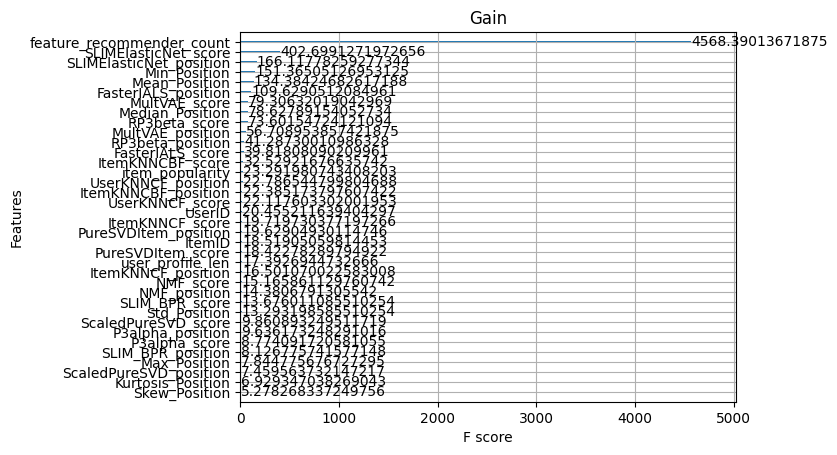

In [29]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='gain', title='Gain')

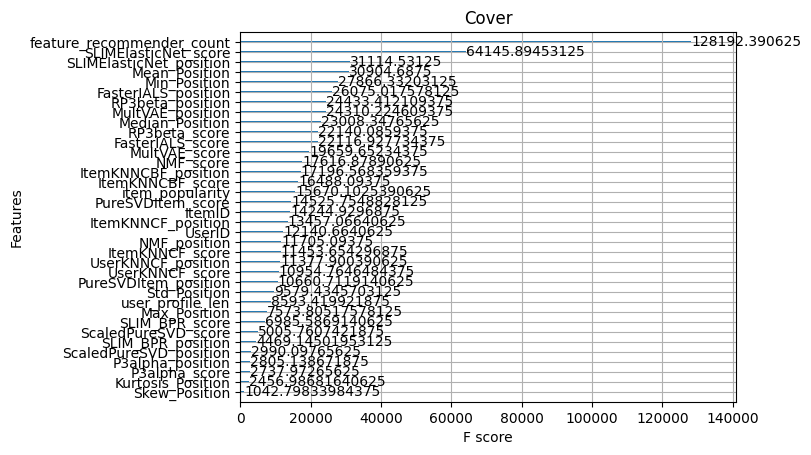

In [30]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='cover', title='Cover')

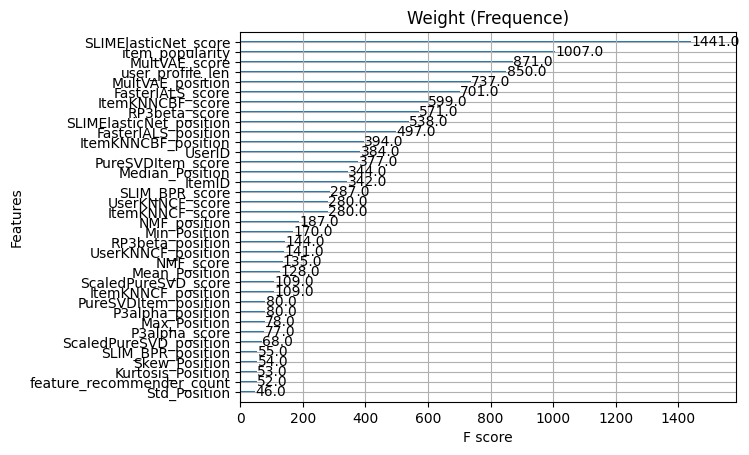

In [31]:
if config['tune_best_params']:
    plot_importance(recommender_instance.model, importance_type='weight', title='Weight (Frequence)')

# Submission

Create the recommendations for the submission.

In [32]:
if config['tune_best_params']:

    data_target_users_test = pd.read_csv('/kaggle/input/recommender-system-2024-challenge-polimi/data_target_users_test.csv')
    create_submission(data_target_users_test, recommender_instance, f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv')

Submission file saved as /kaggle/working/submission_XGBoostNoCont_MAP.csv


# Save Version on GitHub 

Write or import a json file where best hyperparameters are saved. 

In [33]:
if config['tune_parameters']:
    with open(f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 'w') as params_file:
        json.dump(optuna_study.best_params, params_file)
        
    if config['save_github']:
        upload_file(
            f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/best_params_{config["model"]}_{config["metric"]}.json', 
            f'{config["model"]}_{config["metric"]} tuning results (from kaggle notebook)',
            repo
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        f'{K_PATH}/{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/'\
        f'best_params_{config["model"]}_{config["metric"]}.json', 
        f'/kaggle/working/best_params_{config["model"]}_{config["metric"]}.json'
    )

File 'TrainedModels/WithKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/best_params_XGBoostNoCont_MAP.json' created successfully.


Save the history of the tuned model.

In [34]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'], 
        f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/history_{config["model"]}_{config["metric"]}.db',
        f'Tuning {config["model"]}_{config["metric"]} db updated results (from kaggle notebook)',
        repo
    )

File 'TrainedModels/WithKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/history_XGBoostNoCont_MAP.db' created successfully.


Save the best trained model and its submission.

In [35]:
if config['save_github'] and config['tune_best_params']: 
    upload_file(
                f'/kaggle/working/submission_{config["model"]}_{config["metric"]}.csv', 
                f'{GH_PATH}/{D_PATH}/{config["model"]}Recommender/Optimizing{config["metric"]}/Submission/submission_{config["model"]}_{config["metric"]}.csv', 
                f'New {config["model"]}_{config["metric"]} submission (from kaggle notebook)',
                repo
            )

File 'TrainedModels/WithKFCV/XGBoost/XGBoostNoContRecommender/OptimizingMAP/Submission/submission_XGBoostNoCont_MAP.csv' created successfully.
